# MNIST DATASET

### Seeding the model

From talking with our lecturer I found that it was best to seed the random weight generator to get reproducible results. As TensorFlow will automatically assign random weights on each run based on probibility. To achieve this I found documentation on the Keras website below, which I have adapted.

https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

In [1]:
import numpy as np
import tensorflow as tf
import random as rn
from keras import backend as K
import os

Using TensorFlow backend.


The below is necessary for starting Numpy and core Python generated random numbers in a well-defined initial state.

In [2]:
np.random.seed(42)
rn.seed(12345)

Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
For further details, see: https://stackoverflow.com/questions/42022950/

In [3]:
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state. For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

In [4]:
tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

## Additional imports
For Keras, loading the dataset, saving the model, preprocessing and displaying.

In [5]:
import keras as kr
from keras.models import load_model # To save and load models.
from keras.datasets import mnist # Import the MNIST dataset directly from Keras, which is faster.
import sklearn.preprocessing as pre # For encoding categorical variables.
%matplotlib inline
import matplotlib.pyplot as plt # Plot results graphically.
import gzip 
import pandas as pd

## Testing the MNIST dataset
To learn more about how it works.

### Read in the training and test images from gzip file (Slow)

* From testing this is quite slow compared to reading directly from keras.datasets which is used below, but it good for testing and learning how the dataset is structured.

In [6]:
# Adapted from: https://docs.python.org/3/library/gzip.html
# Open the MNIST dataset of 10000 testing images.
with gzip.open('MNIST_Images/t10k-images-idx3-ubyte.gz', 'rb') as f:
    test_imgs = f.read()

# Open the label dataset like before.
with gzip.open('MNIST_Images/t10k-labels-idx1-ubyte.gz', 'rb') as f:
    test_lbls = f.read()

In [7]:
# Print the file type of the dataset - bytes
print("File Type:", type(test_imgs))

# Print out the first four bytes.
# b'\x00\x00\x08\x03' is the output which correlates with the MNIST website results if reading from a gzip.
print("Bytes:", test_imgs[0:4])

# Adapted from: https://stackoverflow.com/questions/51220161/how-to-convert-from-bytes-to-int
# Convert bytes to a 32 bit integer using big-endian and little-endian.
print("Big-endian:", int.from_bytes(test_imgs[0:4], byteorder='big')) #2051
print("Little-endian:", int.from_bytes(test_imgs[0:4], byteorder='little')) #50855936

File Type: <class 'bytes'>
Bytes: b'\x00\x00\x08\x03'
Big-endian: 2051
Little-endian: 50855936


Image label: 4


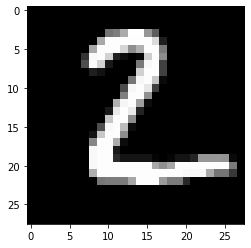

In [8]:
# Display a single image from the dataset
image = np.array(list(test_imgs[800:1584])).reshape(28,28).astype(np.uint8)

# Get the label for a specific image (Expected result = 4)
print("Image label:", int.from_bytes(test_lbls[1:2], byteorder="big"))

# Display plot of image
plt.imshow(image, cmap='gray')
plt.show()

### Read in the training and test images from Keras directly.

* From testing this is considerably faster than reading from the gzip files in memory.

* However when reading from the Keras directly there no header information in the first 16 bytes compared to when reading from the gzip, so it's hard to tell if you're reading it correctly.

In [9]:
(train_imgs, train_lbls), (test_imgs, test_lbls) = mnist.load_data()

## Train the model

#### Set up a neural network model, building it layer by layer sequentially.

In [10]:
model = kr.models.Sequential()

#### Add Layers
Add a hidden layer with 1000 neurons and an input layer with 784 inputs.
* 784 is the number of bytes per image (28 x 28)
* A dense layers means that each neuron recieves input from all the neurons in the previous layer (all connected)
* **linear activation function** = Takes the inputs, multiplied by the weights for each neuron, and creates an output proportional to the input. 
* **relu activation function** = (Rectified Linear Unit) All positive values stay the same and all negative values are changed to zero.

In [11]:
model.add(kr.layers.Dense(units=600, activation='linear', input_dim=784))
model.add(kr.layers.Dense(units=400, activation='relu')) 

Add a 10 neuron output layer, each output will represent a possible label from 0-9.
* softmax - normalizes all outputs so must add up to 1. So the largest weighted result will be the most probable number.
* E.g [0.1, 0.7, 0.1, 0.01...] it will choose 0.7

In [12]:
model.add(kr.layers.Dense(units=10, activation='softmax'))

#### Build the graph.
* categorical_crossentropy - loss function that is used for single label categorization. Used classification problems where only one result can be correct. E.g number is a 9
* adam - Computationally efficient and benefits from both AdaGrad and RMSProp optimizers.
* accuracy - Display accuracy results when training

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Parse image and labels into lists
The bitwise operator ~ (tilde) is a complement operator. It takes one bit operand and returns its complement. If the operand is 1, it returns 0, and if it is 0, it returns 1

In [14]:
train_imgs = np.array(list(train_imgs[:])).reshape(60000, 28, 28).astype(np.uint8) / 255.0
train_lbls = np.array(list(train_lbls[:])).astype(np.uint8)
inputs = train_imgs.reshape(60000, 784)

#### Encode labels into binary using sklearn, so they can be compared easily.
E.g 0 = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1 = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] etc.

In [15]:
encoder = pre.LabelBinarizer()
encoder.fit(train_lbls)
outputs = encoder.transform(train_lbls)

In [16]:
train_lbls[0], outputs[0]

(5, array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0]))

#### Print out binary value for each number 0-9. 

In [17]:
for i in range(10):
    print(i, encoder.transform([i]))

0 [[1 0 0 0 0 0 0 0 0 0]]
1 [[0 1 0 0 0 0 0 0 0 0]]
2 [[0 0 1 0 0 0 0 0 0 0]]
3 [[0 0 0 1 0 0 0 0 0 0]]
4 [[0 0 0 0 1 0 0 0 0 0]]
5 [[0 0 0 0 0 1 0 0 0 0]]
6 [[0 0 0 0 0 0 1 0 0 0]]
7 [[0 0 0 0 0 0 0 1 0 0]]
8 [[0 0 0 0 0 0 0 0 1 0]]
9 [[0 0 0 0 0 0 0 0 0 1]]


### Run and Save the Model
Rather than retraining the model again and again I wanted to be able to save and load it, so I researched and found a way to achieve this.

Code adapted from: https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

In [18]:
# Train model using 8 epochs
# From testing it seems to peak at accuracy at around 8 epochs
# One Epoch is when an entire dataset is passed forward and backward through the neural network only once.
model_log = model.fit(inputs, outputs, epochs=8, batch_size=128)
model.save('test_model.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/8
60000/60000 [==============================] - 7s 110us/step - loss: 0.2234 - acc: 0.9334
Epoch 2/8
60000/60000 [==============================] - 6s 101us/step - loss: 0.0969 - acc: 0.9701
Epoch 3/8
60000/60000 [==============================] - 6s 101us/step - loss: 0.0716 - acc: 0.9777
Epoch 4/8
60000/60000 [==============================] - 6s 101us/step - loss: 0.0602 - acc: 0.9811
Epoch 5/8
60000/60000 [==============================] - 6s 108us/step - loss: 0.0545 - acc: 0.9827 0s - loss: 0.0541 - acc: 0.9
Epoch 6/8
60000/60000 [==============================] - 6s 100us/step - loss: 0.0472 - acc: 0.9846
Epoch 7/8
60000/60000 [==============================] - 6s 102us/step - loss: 0.0409 - acc: 0.9867
Epoch 8/8
60000/60000 [==============================] - 7s 109us/step - loss: 0.0364 - acc: 0.9885


#### Display accuracy and loss results on a graph
Code adapted from: https://towardsdatascience.com/a-simple-2d-cnn-for-mnist-digit-recognition-a998dbc1e79a

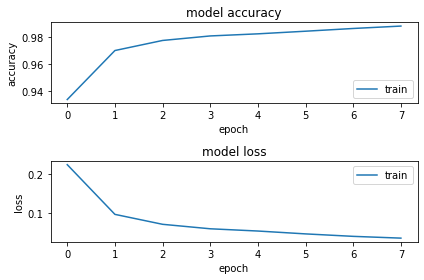

In [19]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(model_log.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(model_log.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

## Test the model.
Parse images and labels into lists.

In [20]:
test_imgs = np.array(list(test_imgs[:])).reshape(10000, 784).astype(np.uint8) / 255.0
test_lbls = np.array(list(test_lbls[:])).astype(np.uint8)

#### Get the sum of correct values 
Calculate the sum of correct results out of all 10000 images using the labels
* Last test returned a result of 9850. 

In [21]:
print("\nSum of correct results:", (encoder.inverse_transform(model.predict(test_imgs)) == test_lbls).sum())


Sum of correct results: 9764


#### Predict image using model
Pick an image from the test images, and call predict. ([11:12], is the number 6.)

In [22]:
print("\nTest image:", model.predict(test_imgs[11:12]))


Test image: [[3.96300538e-06 1.35781186e-14 6.21584695e-09 1.99108174e-09
  1.20316435e-09 3.22251822e-06 9.99523401e-01 1.68428487e-12
  4.69455757e-04 3.77255605e-12]]


From testing the model.predict it would return an array of possibilities. The highest value would be the right answer.
To get the largest value I looked how to get the index of the highest value in a numpy array and found argmax() which does this nicely.

Code adapted from: https://kite.com/python/examples/5750/numpy-find-the-index-of-the-largest-element-of-an-array

In [23]:
print("\nResults:", model.predict(test_imgs[11:12]).argmax())


Results: 6


#### Display correct image 
If it's the same as the predicted above then the prediction is correct.

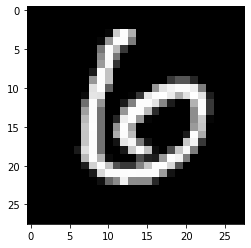

In [24]:
plt.imshow(test_imgs[11].reshape(28, 28), cmap='gray')
plt.show()